# Introduction

In this project I have built a model for predicting readmission for patients with diabetes in Python using the following steps
- data exploration
- feature engineering
- building training/validation/test samples
- model selection
- model evaluation

# Data set exploration

The dataset used is the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
df = pd.read_csv('diabetic_data.csv')

In [4]:
print('Total samples:',len(df))

Total samples: 101766


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
# Unique target values
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

In [8]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

 I removed the samples with the ids 11,13,14,19,20,21 as they represent patient death. I obtained this from IDs_mapping.csv file.


In [9]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

OUTPUT_LABEL is the prediction variable which will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [10]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

In [11]:
#Find prevalence of population admitted within 30 days
def preval(actualY):
    return (sum(actualY)/len(actualY))
print('Prevalence:%.3f'%preval(df['OUTPUT_LABEL'].values))

Prevalence:0.114


Only 11% of the population is rehospitalized. Hence our problem is an imbalance class problem.

We need to find the unique values in each column to better understand and preprocess the data

In [12]:
#Finding the unique values in each column
for col in list(df.columns):

    # Print all unique values
    num = df[col].unique()

    # print number of unique values if count>30
    if len(num)<30:
        print(col)
        print(num)
    else:
        print(col + ': ' +str(len(num)) + ' different vals')

encounter_id: 99343 different vals
patient_nbr: 69990 different vals
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 different vals
num_lab_procedures: 118 different vals
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 different vals
number_outpatient: 39 different vals
number_emergency: 33 different vals
number_inpatient
[ 0  1  2

Detecting OUTLIERS

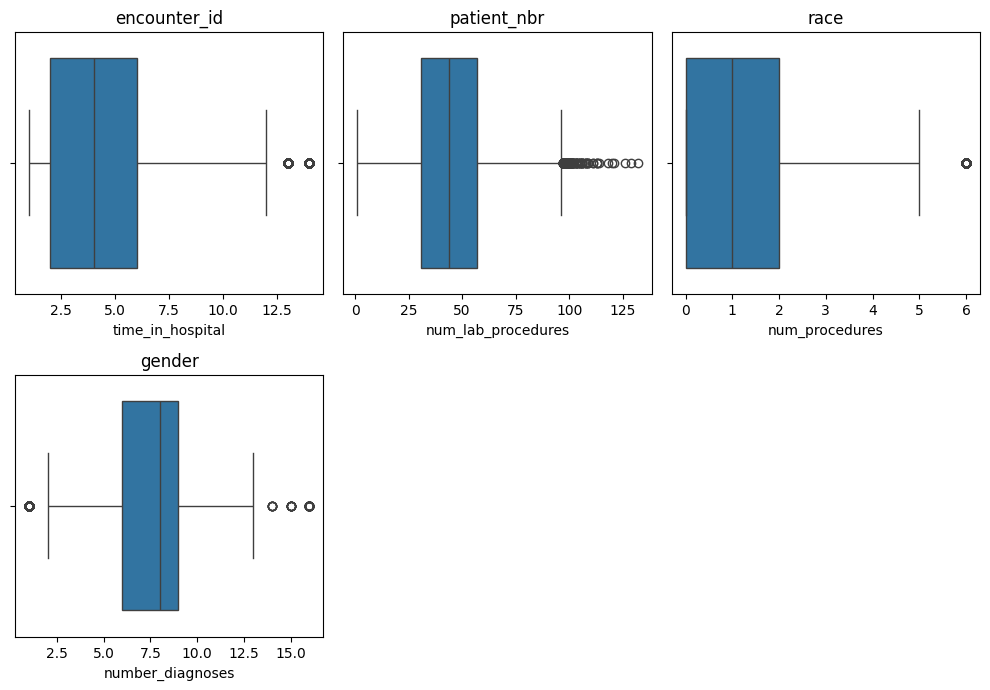

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

num_columns = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'number_diagnoses']
# plot for outliers detection
plt.figure(figsize=(10,10))
for i in range(len(df[num_columns].columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df[num_columns[i]])
    plt.title(df.columns[i])

plt.tight_layout()

We can ignore the above data as not many outliers are found

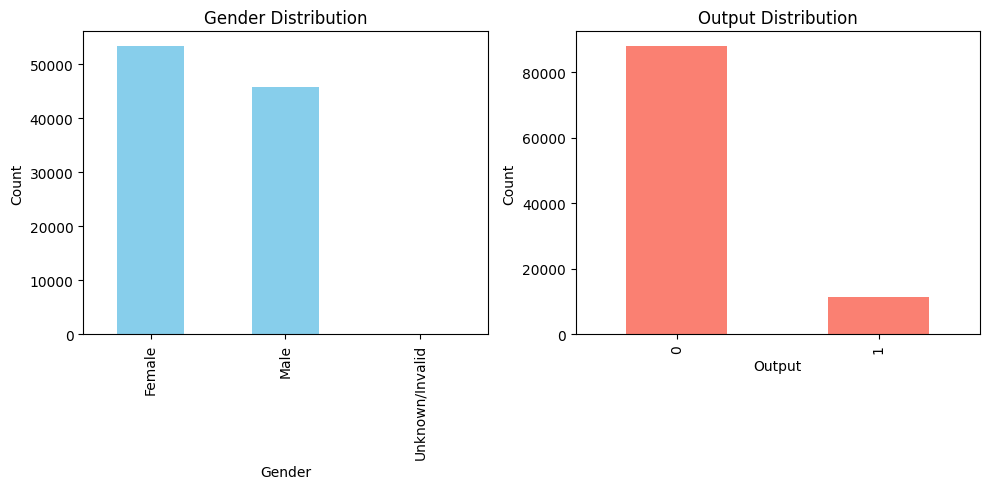

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
gender_counts = df['gender'].value_counts()
output_label = df['OUTPUT_LABEL'].value_counts()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
gender_counts.plot(kind='bar', color='skyblue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
output_label.plot(kind='bar', color='salmon')
plt.title('Output Distribution')
plt.xlabel('Output')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Correlation Map

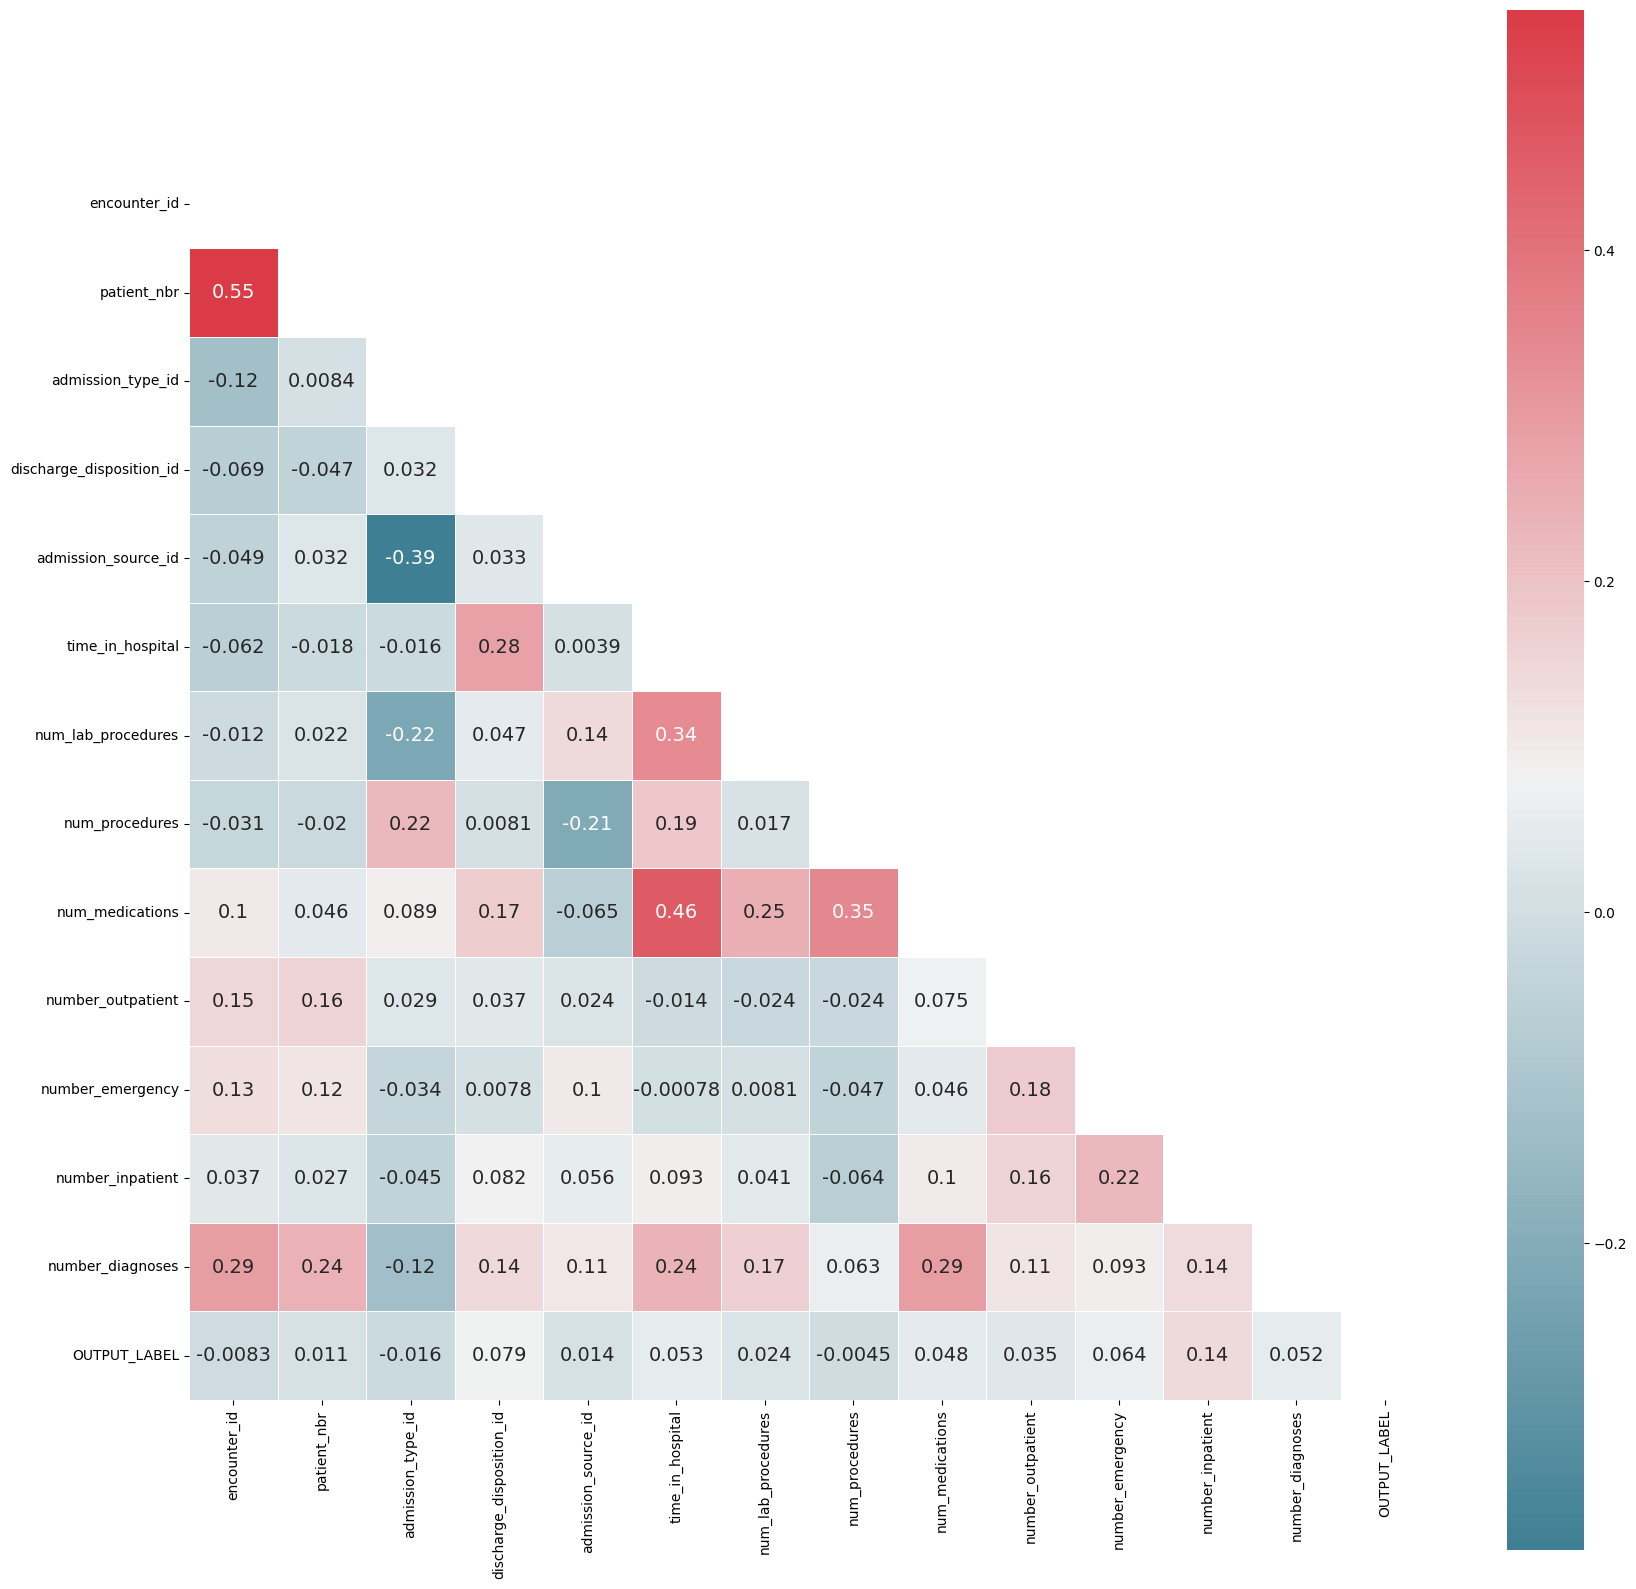

In [15]:
correlation = df.select_dtypes(include=np.number).corr(method= 'spearman')

fig, ax = plt.subplots()

ax.figure.set_size_inches(20, 20)
mask = np.triu(np.ones_like(correlation, dtype=np.bool_))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5,
            annot=True, annot_kws={'size':14})

plt.show()

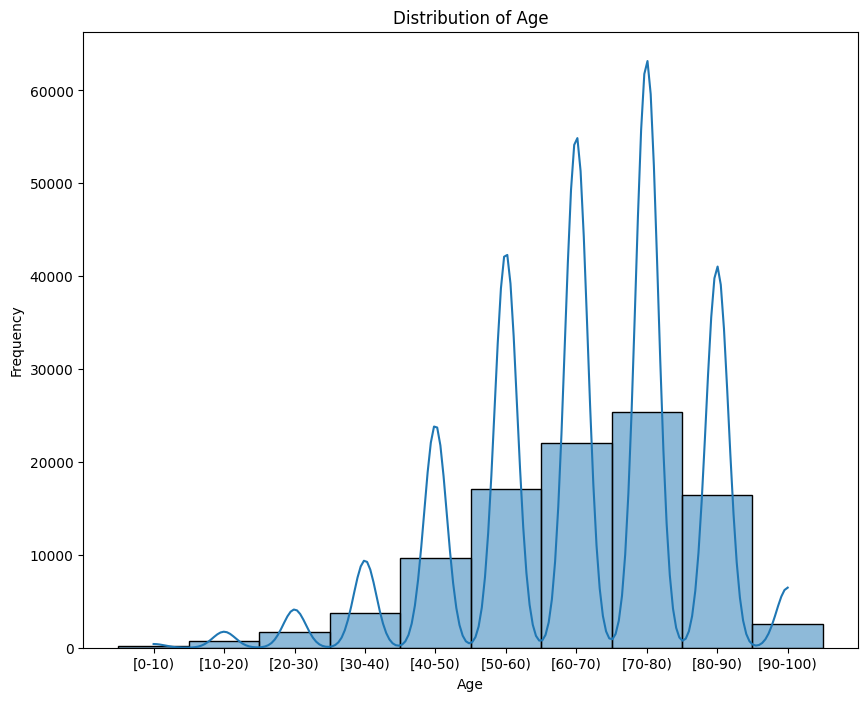

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='age', bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



# Feature Engineering

In [17]:
# replace missing values with NAN
df = df.replace('?',np.nan)

In [18]:
#These columns are numerical data
num_columns = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [19]:
#These columns contain categorical data
cat_columns = ['race', 'gender',
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [20]:
#Checking for missing values
df[cat_columns].isnull().sum()

race                         2234
gender                          0
max_glu_serum               94191
A1Cresult                   82509
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

In [21]:
#Fill missing values with UNKNOWN
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

In [22]:
#Finding unique number of specialities
print('Medical Specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Medical Specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

We can see that many categories have only 1 value in them. So we can bucket all these categories together, and name it as Others.

In [23]:
#Bucketing data
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

df['med_spec'] = df['medical_specialty'].copy()

df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [24]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

In [25]:
#Converting to string type for encoding
catnum_columns = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[catnum_columns] = df[catnum_columns].astype('str')

In [26]:
#One hot encoding of all categorical variables
df_cat = pd.get_dummies(df[cat_columns + catnum_columns + ['med_spec']],drop_first = True)

In [27]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>8,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [28]:
#Adding the encoded dataframe to main dataframe
df = pd.concat([df,df_cat], axis = 1)

In [29]:
allcategorical = list(df_cat.columns)

In [30]:
#These features are extra
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [31]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [32]:
#Since age is given as categorical, I try to convert it into numerical
age_encoding = {'[0-10)':0,
          '[10-20)':10,
          '[20-30)':20,
          '[30-40)':30,
          '[40-50)':40,
          '[50-60)':50,
          '[60-70)':60,
          '[70-80)':70,
          '[80-90)':80,
          '[90-100)':90}
df['age_group'] = df.age.replace(age_encoding)

In [33]:
df.weight.notnull().sum()

3125

In [34]:
#I created a column which indicates if weight is Null or not Null
df['has_weight'] = df.weight.notnull().astype('int')

In [35]:
extra_columns = ['age_group','has_weight']

In [36]:
#Printing final details of the dataset
print('Total features:', len(num_columns + allcategorical + extra_columns))
print('Categorical Features:',len(allcategorical))
print('Numerical Features:',len(num_columns))
print('Extra features:',len(extra_columns))

Total features: 141
Categorical Features: 131
Numerical Features: 8
Extra features: 2


In [37]:
neededcols = num_columns + allcategorical + extra_columns
final_df = df[neededcols + ['OUTPUT_LABEL']]

# Building Training/Validation/Test Samples

I use 70% of data for training, 15% for validation and 15% for testing
I use a 70-15-15 split

In [38]:
# Shuffling the dataset
final_df = final_df.sample(n = len(final_df), random_state = 42)
final_df = final_df.reset_index(drop = True)

In [39]:
# I use 70-30 splitting for training and testing
df_vtest=final_df.sample(frac=0.30,random_state=42)
print('Splitting ratio: %.3f'%(len(df_vtest)/len(final_df)))

Splitting ratio: 0.300


In [40]:
# I use 50-50 split for testing and validation
df_test = df_vtest.sample(frac = 0.5, random_state = 42)
df_valid = df_vtest.drop(df_test.index)

In [41]:
# Initializing training set
df_training=final_df.drop(df_vtest.index)

In [42]:
# I am subsampling the negative labels as they are huge in number compared to the positive labels
# This is done as it is an imbalanced dataset
# split the training data into positive and negative labels

positiverows = df_training.OUTPUT_LABEL == 1
positive_dftrain = df_training.loc[positiverows]
negative_dftrain = df_training.loc[~positiverows]

# training data is subsampled
df_train = pd.concat([positive_dftrain, negative_dftrain.sample(n = len(positive_dftrain), random_state = 42)],axis = 0)

# shuffling the dataset
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), preval(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


In [43]:
#Creating X feature set and Y target variable for model fitting

X_train = df_train[neededcols].values
X_train_all = df_training[neededcols].values
X_valid = df_valid[neededcols].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

In [44]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [45]:
import pickle
scalerfile = 'scaler.sav'

#Saving the scaler file using pickle
pickle.dump(scaler, open(scalerfile, 'wb'))

In [46]:
scaler = pickle.load(open(scalerfile, 'rb'))

In [47]:
#Transforming the data using StandardScaler
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def specval(actualY, predY, thresh):
    return sum((predY < thresh) & (actualY == 0)) /sum(actualY ==0)

def resultoutput(actualY, predY, thresh):
    auc = roc_auc_score(actualY, predY)
    accuracy = accuracy_score(actualY, (predY > thresh))
    recall = recall_score(actualY, (predY > thresh))
    precision = precision_score(actualY, (predY > thresh))
    specificity = specval(actualY, predY, thresh)
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('Specificity:%.3f'%specificity)
    print('Prevalence:%.3f'%preval(actualY))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [49]:
thresh = 0.5

### K nearest neighbors (KNN)

In [50]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
#Initialize model
knn=KNeighborsClassifier(n_neighbors = 100)
#Fit the model
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [51]:
trainpredY = knn.predict_proba(X_train_tf)[:,1]
validpredY = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = resultoutput(y_train,trainpredY, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = resultoutput(y_valid,validpredY, thresh)

KNN
Training:
AUC:0.650
Accuracy:0.606
Recall:0.487
Precision:0.638
Specificity:0.676
Prevalence:0.500
 
Validation:
AUC:0.620
Accuracy:0.671
Recall:0.466
Precision:0.164
Specificity:0.659
Prevalence:0.113
 


### Logistic regression

In [52]:
# Logistic Regrassion
from sklearn.linear_model import LogisticRegression
#Initializing model
lr=LogisticRegression(random_state = 42)
#Fitting the model
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [53]:
trainpredY = lr.predict_proba(X_train_tf)[:,1]
validpredY = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = resultoutput(y_train,trainpredY, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = resultoutput(y_valid,validpredY, thresh)

Logistic Regression
Training:
AUC:0.678
Accuracy:0.627
Recall:0.558
Precision:0.648
Specificity:0.697
Prevalence:0.500
 
Validation:
AUC:0.660
Accuracy:0.663
Recall:0.555
Precision:0.179
Specificity:0.677
Prevalence:0.113
 


### Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [55]:
trainpredY = nb.predict_proba(X_train_tf)[:,1]
validpredY = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =resultoutput(y_train,trainpredY, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = resultoutput(y_valid,validpredY, thresh)

Naive Bayes
Training:
AUC:0.508
Accuracy:0.506
Recall:0.989
Precision:0.503
Specificity:0.022
Prevalence:0.500
 
Validation:
AUC:0.505
Accuracy:0.129
Recall:0.988
Precision:0.114
Specificity:0.020
Prevalence:0.113
 


### Decision Tree Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [57]:
trainpredY = tree.predict_proba(X_train_tf)[:,1]
validpredY = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =resultoutput(y_train,trainpredY, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = resultoutput(y_valid,validpredY, thresh)

Decision Tree
Training:
AUC:0.734
Accuracy:0.669
Recall:0.631
Precision:0.683
Specificity:0.705
Prevalence:0.500
 
Validation:
AUC:0.626
Accuracy:0.636
Recall:0.574
Precision:0.170
Specificity:0.641
Prevalence:0.113
 


### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [59]:
trainpredY = rf.predict_proba(X_train_tf)[:,1]
validpredY = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
auc_trainopt, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =resultoutput(y_train,trainpredY, thresh)
print('Validation:')
auc_validopt, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = resultoutput(y_valid,validpredY, thresh)

Random Forest
Training:
AUC:0.692
Accuracy:0.639
Recall:0.608
Precision:0.648
Specificity:0.670
Prevalence:0.500
 
Validation:
AUC:0.658
Accuracy:0.628
Recall:0.604
Precision:0.173
Specificity:0.631
Prevalence:0.113
 


### SVM


In [60]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_tf, y_train)

SVC(probability=True)

In [61]:
trainpredY = svm.predict_proba(X_train_tf)[:, 1]
validpredY = svm.predict_proba(X_valid_tf)[:, 1]

print('SVM')
print('Training:')
svm_train_auc, svm_train_accuracy, svm_train_recall, svm_train_precision, svm_train_specificity =resultoutput(y_train,trainpredY, thresh)
print('Validation:')
svm_valid_auc, svm_valid_accuracy, svm_valid_recall, svm_valid_precision, svm_valid_specificity = resultoutput(y_valid,validpredY, thresh)

SVM
Training:
AUC:0.772
Accuracy:0.702
Recall:0.654
Precision:0.724
Specificity:0.729
Prevalence:0.500
 
Validation:
AUC:0.656
Accuracy:0.651
Recall:0.576
Precision:0.178
Specificity:0.639
Prevalence:0.113
 


## Comparing the models

In [62]:
results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','NB','NB','DT','DT','RF','RF','SVM','SVM'],
                           'data_set':['training','validation']*6,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,auc_trainopt,auc_validopt,svm_train_auc,svm_valid_auc],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,svm_train_accuracy,svm_valid_accuracy],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,svm_train_recall,svm_valid_recall],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,svm_train_precision,svm_valid_precision],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,svm_train_specificity,svm_valid_specificity]})

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

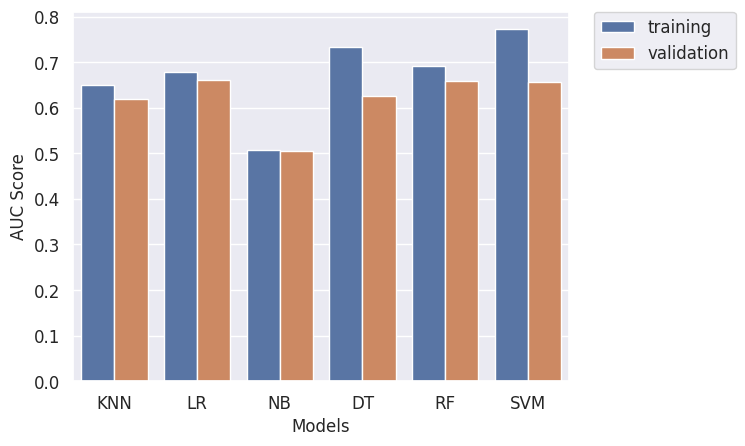

In [64]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=results)
ax.set_xlabel('Models',fontsize = 12)
ax.set_ylabel('AUC Score', fontsize = 12)
ax.tick_params(labelsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 12)
plt.show()

## Hyperparameter tuning : Random Forest

I will only optimize the hyper parameters for random forest. I will not optimize KNN, SVM and Logistic Regression since it took a while to train. I will not optimize decision trees since they tend to overfit and perform worse that random forests.

In [65]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Setting the number of trees
n_estimators = range(200,1000,200)

# Maximum features
max_features = ['auto','sqrt']

# Maximum depth
max_depth = range(1,10,1)

# Min samples required to split node
min_samples_split = range(2,10,2)

# Setting the criterion
criterion = ['gini','entropy']

# Setting a random grid
random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [67]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [68]:
randomCV = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [69]:
randomCV.fit(X_train_tf, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(max_depth=6,
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(200, 1000, 200)},
                   random_state=42, scoring=make_scorer(roc_auc_score),
                   verbose=1)

In [70]:
randomCV.best_params_

{'n_estimators': 600,
 'min_samples_split': 6,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'gini'}

In [71]:
#Comparing baseline model with optimized model for Random Forest

trainpredY = rf.predict_proba(X_train_tf)[:,1]
validpredY = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
auc_trainbase = roc_auc_score(y_train, trainpredY)
auc_validbase = roc_auc_score(y_valid, validpredY)
print('Training AUC:%.3f'%(auc_trainbase))
print('Validation AUC:%.3f'%(auc_validbase))

print('Optimized Random Forest')

trainpredY_random = randomCV.best_estimator_.predict_proba(X_train_tf)[:,1]
validpredY_random = randomCV.best_estimator_.predict_proba(X_valid_tf)[:,1]

auc_trainopt = roc_auc_score(y_train, trainpredY_random)
auc_validopt = roc_auc_score(y_valid, validpredY_random)
print('Training AUC:%.3f'%(auc_trainopt))
print('Validation AUC:%.3f'%(auc_validopt))

Baseline Random Forest
Training AUC:0.692
Validation AUC:0.658
Optimized Random Forest
Training AUC:0.722
Validation AUC:0.663


### Hyperparameter tuning results

In [72]:
results = pd.DataFrame({'classifier':['RF','RF'],
                           'data_set':['base','optimized'],
                          'auc':[auc_validbase,auc_validopt],
                          })

In [73]:
results

,classifier,data_set,auc
0,RF,base,0.657812
1,RF,optimized,0.662969


There is not much improvement even after optimization


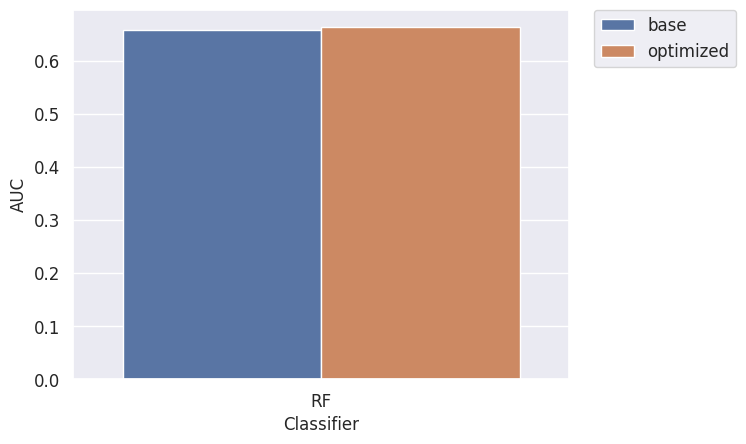

In [74]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=results)
ax.set_xlabel('Classifier',fontsize = 12)
ax.set_ylabel('AUC', fontsize = 12)
ax.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 12)

plt.show()

## Best Classifier

 I have chosen the optimzed Random Forest classifier since it has the best AUC on the validation set.

In [75]:
pickle.dump(randomCV.best_estimator_, open('bestmodel.pkl', 'wb'),protocol = 4)

# Model Evaluation

In [76]:
X_test = df_test[neededcols].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [77]:
best_model = pickle.load(open('bestmodel.pkl','rb'))


In [78]:
trainpredY = best_model.predict_proba(X_train_tf)[:,1]
validpredY = best_model.predict_proba(X_valid_tf)[:,1]
testpredY = best_model.predict_proba(X_test_tf)[:,1]


In [79]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = resultoutput(y_train,trainpredY, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = resultoutput(y_valid,validpredY, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = resultoutput(y_test,testpredY, thresh)

Training:
AUC:0.722
Accuracy:0.659
Recall:0.627
Precision:0.670
Specificity:0.691
Prevalence:0.500
 
Validation:
AUC:0.663
Accuracy:0.629
Recall:0.602
Precision:0.173
Specificity:0.633
Prevalence:0.113
 
Test:
AUC:0.661
Accuracy:0.627
Recall:0.609
Precision:0.179
Specificity:0.630
Prevalence:0.117
 


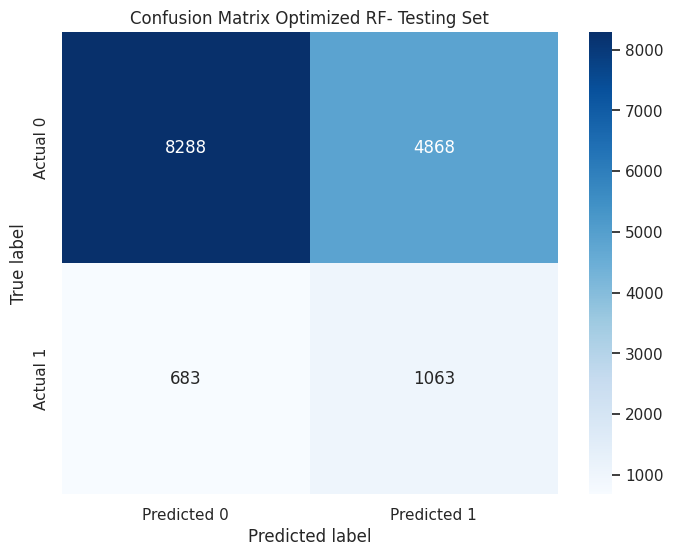

In [80]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrix for testing set
testpredYcm = best_model.predict(X_test_tf)
test_cm = confusion_matrix(y_test, testpredYcm)


plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix Optimized RF- Testing Set')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


While the accuracy is a straightforward metric, it might not fully capture the clinical importance of these predictions.

Recall (Sensitivity): The recall for predicting readmission is calculated as TP / (TP + FN) = 1,063 / (1,063 + 683) = 0.609 or 60.9%. This metric is crucial because it reflects the model's ability to correctly identify those who will be readmitted. High recall is important as missing out on patients who are likely to be readmitted (false negatives) can lead to inadequate patient care and potential health risks.

Importance of High Recall over Accuracy: In the context of hospital readmissions, it is crucial to minimize false negatives. A false negative in this scenario means a patient who needs careful monitoring could be overlooked, potentially leading to severe complications or even fatal outcomes.

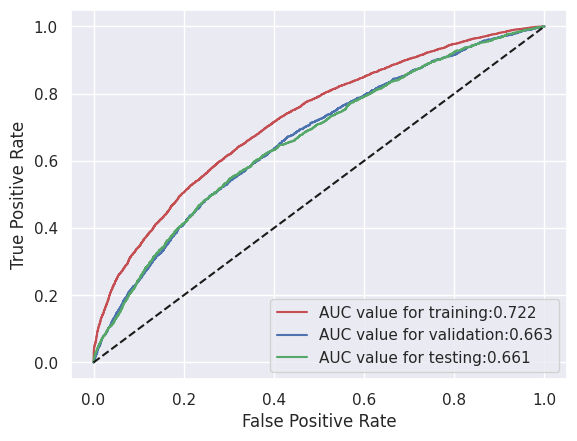

In [81]:
from sklearn.metrics import roc_curve

falseposrate_train, trueposrate_train, thresh_train = roc_curve(y_train, trainpredY)
aucscore_train = roc_auc_score(y_train, trainpredY)

falseposrate_valid, trueposrate_valid, thresh_valid = roc_curve(y_valid, validpredY)
aucscore_valid = roc_auc_score(y_valid, validpredY)

falseposrate_test, trueposrate_test, thresholds_test = roc_curve(y_test, testpredY)
aucscore_test = roc_auc_score(y_test, testpredY)

plt.plot(falseposrate_train, trueposrate_train, 'r-',label ='AUC value for training:%.3f'%aucscore_train)
plt.plot(falseposrate_valid, trueposrate_valid, 'b-',label ='AUC value for validation:%.3f'%aucscore_valid)
plt.plot(falseposrate_test, trueposrate_test, 'g-',label ='AUC value for testing:%.3f'%aucscore_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusion

Through this project, I have created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. Our best model had an AUC of of 0.66. This model is able to catch 60% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients.